# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

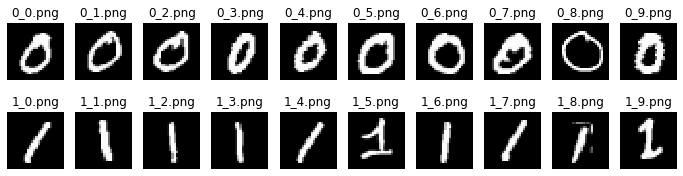

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

### 1.3 Additional method(s)

#### 1.3.1 Simple region-based descriptors

Here we analyse simple descriptors that depend on the object region :_region based descriptors_.

In [3]:
import cv2
from skimage import measure, transform, morphology
import numpy as np
from scipy import ndimage
from skimage import morphology

In [ ]:
# Preparation for plotting features
def rotation(image):
    '''
    Applying rotation to get more images.
    A rotation affect the phase of all the descriptors by the same amount, and does not modify their amplitude
    '''
    rotate90d = [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate180d = [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate270d = [transform.rotate(i, 270, resize=False, preserve_range=True).astype('uint8') for i in image]
    return  list(image) + rotate90d + rotate180d + rotate270d

def featureImages(im, f1, f2):
    imageRotated = rotation(im)
    features = []
    for i in imageRotated:
        a1 = f1(i)
        a2 = f2(i)
        features.append([a1, a2])
    features = np.array(features)
    return features, [f1.__name__, f2.__name__]

def _pltF(imFeatures, features, labels):
    plt.figure(figsize=(8,8))
    for f, l, c in zip(imFeatures, labels, ['r', 'b']):
        plt.scatter(f[:,0], f[:,1], label=l, c=c, s=50)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.grid(True)
    plt.title('{} vs {} descriptors'.format(features[0], features[1]))
    
def plotFeatures(method1, method2):
    listImages = [zeros_im, ones_im]
    listImagesResult = []
    for im in listImages:
        imF, fName = featureImages(im, method1, method2)
        listImagesResult.append(imF)
    _pltF(listImagesResult, fName, range(len(listImages)))

##### 1.3.1.1 Compacity

Compacity is the ratio of perimeter square to the object area. It describes compactness of the object. For example, 
circle has the minimum compacity. Compycity is invariant to the rotation. 

In [ ]:
from skimage import measure
def compacity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    P = measure.perimeter(thresh1>0, neighbourhood=1)
    A = np.count_nonzero(thresh1)
    C = (P**2)/A
    return C

##### 1.3.1.2 Elongation

Elongation is the ratio between  the maximum diameter of the object and its minimum diameter perpendicular to it. It is 
also invariant to the object rotation.

In [ ]:
def elongation(image):
    image = ndimage.grey_opening(image,size = (2,2))
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    moment = cv2.moments(thresh1)
    xcoor = moment['mu20'] + moment['mu02']
    ycoor = 4 * moment['mu11']**2 + (moment['mu20'] - moment['mu02'])**2
    return (xcoor + ycoor**0.5) / (xcoor - ycoor**0.5)


##### 1.3.1.3 Rectangularity
Rectangularity is the ratio between the object area and its largest circumscript rectangle. 

In [ ]:
def rectangularity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    _, contour, _ = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # area = cv2.contourArea(contour[0])
    area = np.count_nonzero(thresh1)
    xcoor, ycoor, width, height = cv2.boundingRect(contour[0])
    rect_area = width*height
    rectangularitY = float(area)/rect_area
    return rectangularitY

##### 1.3.1.4 Perimeter

Perimeter of the detected contour for each object is another desciptor that we would like to examine.
We first binarize each image with a threshold, and then calculate the perimeter with 1 neighbour connectivity on binary image. 

In [ ]:
def perimeter(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    perimeter = measure.perimeter(thresh1>0, neighbourhood=1)
    return perimeter

##### 1.3.1.5 results and discussion
* __compacity__ vs __elongation__:<br />
According to the plot bellow compacity of 0 is larger than compacity of 1 values.  
Furthermore, elongation of number 1 images has larger variance than elongation of number 0. 
Compacity is also larger than circle compacity (4$\pi$) which is validated by our results.
Two image sets are separable in the 2D plot. Therefore, both compacity and elongation are appropriate descriptors for our images. 

In [ ]:
plotFeatures(compacity, elongation)

* __compacity__ vs __rectangularity__:<br />
According to the result, rectangularity of two image sets is not separate enough. We can conclude that rectangularity is not 
an appropriate descriptor for our data.

In [ ]:
plotFeatures(compacity, rectangularity)

* __compacity__ vs __perimeter__:<br />
The result bellow confirms that perimeter is an appropriate descriptor for our data. Indeed, perimeter values for iamges 
number 1 and 0 are separate with each other. We can conclude that using both compacity and perimeter can provide us the 
best simple region based descriptors for our dataset.

In [ ]:
plotFeatures(compacity, perimeter)

#### 1.3.2 Skeleton

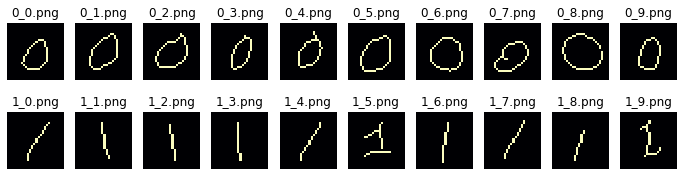

In [34]:
from skimage.morphology import skeletonize
import cv2
import numpy as np

skeleton_zero=[]
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,220,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))

skeleton_one=[]
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))

# Plotting the skeletons
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3)) 
for ax, im, nm in zip(axes[0], skeleton_zero, zeros_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], skeleton_one, ones_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)


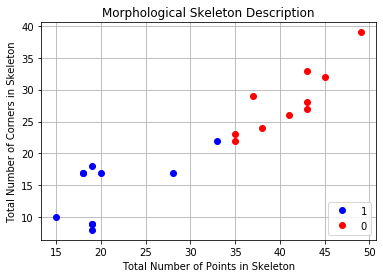

In [36]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
    
# Removing the first and last rows and columns from images    
_,h,w= np.shape(skeleton_one)
h=h-1
w=w-1
skeleton_one_check=skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 

# Plotting the features plot
Plot_ones = plt.plot(Total_number_of_points1,Total_number_of_corners1, "o", label="1", c='b')
Plot_zeros = plt.plot(Total_number_of_points0,Total_number_of_corners0, "o", label="0", c='r')
plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Total Number of Corners in Skeleton')
plt.title('Morphological Skeleton Description')
plt.grid(True)
plt.show()

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

In [ ]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

In [ ]:
# Harris Corner Detector
# #%% md
###### 1.3.1.4 Corner numbers
#
#Here 
##%%
# def corner_counting(image):
#     image = ndimage.grey_opening(image,size = (2,2))
#     _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
#     # harris_dst (--> output of Harris edge detector) – Image to store the Harris detector responses.
#     harris_dst = cv2.cornerHarris(thresh1,2,3,0.04)
#     # Threshold for an optimal value, threshold value may vary depending on the image.
#     numbers = thresh1[harris_dst>0.01*harris_dst.max()].shape 
#     return numbers[0]
# 
# plotFeatures(corner_counting, compacity)
# 
